In [6]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import hvplot.pandas
import panel as pn

pn.extension(comms="vscode")


import arable_api

# Accessing the Arable data on SheHulk (10.81.205.13)

The data from the sensors is being downloaded daily at 3am, so the data for previous dates should be available on
the `/mnt/me4084b/users/jose/KCL_Arable/raw_data` directory, or via the web interface on [this website](http://10.81.205.13/jose/arable_data_files/). The files are all in CSV format, and there's one file per day. Download logs are also available in `/mnt/me4084b/users/jose/KCL_Arable/logs`.

# Exploring the files

We will have a look at the different data files first. 

In [2]:
loc = Path("/mnt/me4084b/users/jose/KCL_Arable/raw_data")
# Search for all the CSV files under the data directory
file_names = [f for f in loc.glob("*.csv")]

CSV filenames following the following naming pattern:

`{date}_{schema}.csv`

* `{date}` is the date using the `YYYY-MM-DD` format.
* `{schema}` is the name of the schema. Most of the interesting data will be in `hourly` or `daily`, but there's a bunch of them to consider. I'm also not very sure what some of them are.
  
  Let's see some of these schemas:

In [3]:
schemas = np.unique([f.name.split("_")[1].rstrip(".csv") for f in file_names])
print(schemas)

['calibrated' 'daily' 'data' 'deployment' 'dsd' 'health' 'hourly' 'local'
 'location' 'network' 'sentek']


In [27]:
pd.DataFrame(arable_api.get_response("schemas/hourly"))

,column_name,data_type,description
0,b1dw,real,Spectrometer data bands 1-7 downwelling (W/m^2)
1,b1uw,real,Spectrometer data bands 1-7 upwelling (W/m^2)
2,b2dw,real,Spectrometer data bands 1-7 downwelling (W/m^2)
3,b2uw,real,Spectrometer data bands 1-7 upwelling (W/m^2)
4,b3dw,real,Spectrometer data bands 1-7 downwelling (W/m^2)
5,b3uw,real,Spectrometer data bands 1-7 upwelling (W/m^2)
6,b4dw,real,Spectrometer data bands 1-7 downwelling (W/m^2)
7,b4uw,real,Spectrometer data bands 1-7 upwelling (W/m^2)
8,b5dw,real,Spectrometer data bands 1-7 downwelling (W/m^2)
9,b5uw,real,Spectrometer data bands 1-7 upwelling (W/m^2)


We can load up the data. We just ensure that the `timex` column is the one to use as the (time) index.
This is done as follows:

In [12]:
df = pd.concat(
    [
        pd.read_csv(f, parse_dates=["timex"])
        for f in file_names
        if f.stem[11:] == "hourly"
    ]
)
df = df.set_index("timex")

Let's now define a function to plot time series of a given parameter per device, and use it to plot ET and ETc.

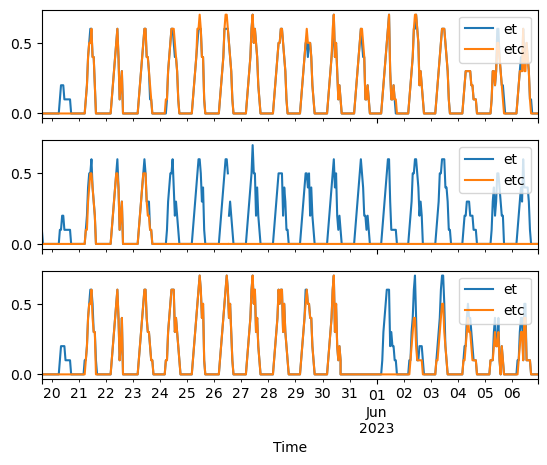

In [36]:
def plot_tseries_device(params:list) -> None:
    devs = np.unique(df.device.values)
    fig, axs = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=True)
    axs = axs.flatten()
    for i, dev in enumerate(devs):
        for p in params:
            df[df.device == dev].plot(y=p, ax=axs[i])
        axs[i].set_xlabel("Time")

plot_tseries_device(["et", "etc"])

Now, let's see shortwave upwelling and downwelling radiation over time:

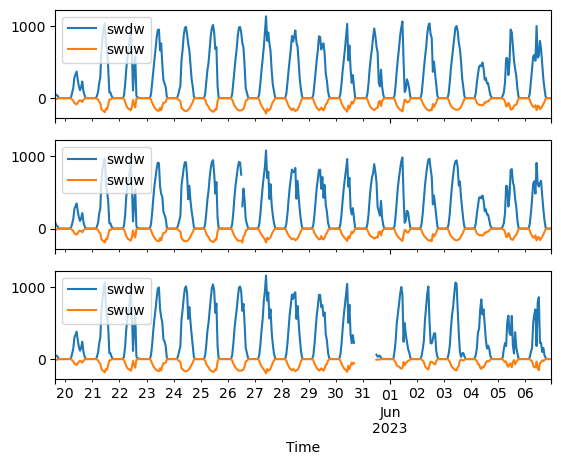

In [37]:
plot_tseries_device(["swdw", "swuw"])

Let's look at the air and leaf/ground temperatures:

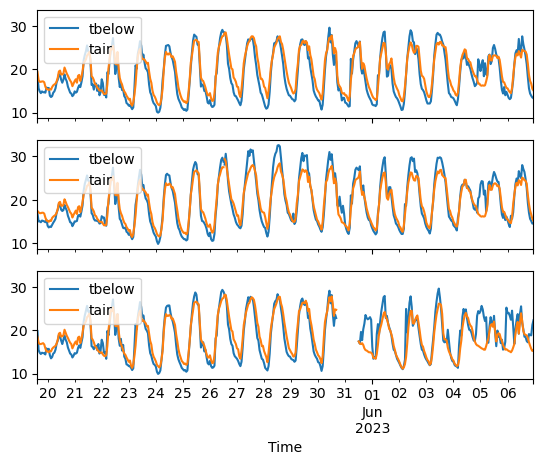

In [38]:
plot_tseries_device(["tbelow", "tair"])